In [4]:
# loading dataframes
import numpy as np
import pandas as pd
import json

# system traversal
import os
import re
import zipfile

# seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# plotly html charting
from plotly import tools
import plotly.graph_objs as go
import plotly.plotly as py


# data processing
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split, GroupKFold
import category_encoders as ce
from xgboost import XGBRegressor

# measurement metrics
from sklearn.metrics import classification_report, make_scorer, mean_squared_error, mean_squared_log_error

# custom classes
from sklearn.base import BaseEstimator, TransformerMixin

# charting paramemters
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
                })


## Data import

In [5]:
def json_parse(row):
    return json.loads(row)

json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
files = os.listdir('../../data/')

print(files)

chunks = pd.read_csv(
                   '../../data/' + files[0], converters={'device':json_parse, 'geoNetwork':json_parse, 
                                                      'totals':json_parse, 'trafficSource':json_parse},
                    chunksize = 20000,
    nrows = 100000
                  )

with zipfile.ZipFile(f'../../data/{files[0]}') as f:
    print(f.namelist())

['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip', 'out']
['train.csv']


In [6]:
def proc_chunks(chunks):
    df_list = []
    for chunk in chunks:
        df_list.append(proc_data(chunk))
    data = pd.concat(df_list, sort = False)
    print(data.shape)
    
    # convert columns
    data['visitStartTime'] = pd.to_datetime(data.visitStartTime, unit = 's')
    data['campaignCode'] = data.campaignCode.fillna('unknown')
    data['transactionRevenue'] = data.transactionRevenue.fillna(0).astype(int)
    
    return data

def combine_dict(series):
    
    
    n = len(series)
    final_dict = dict()
    
    def get_keys(series):
   
        n = len(series)
        for i in range(n):
            cur = json.loads(series[i])
            uncommon = final_dict.keys() ^ cur.keys()
            
            if uncommon is not set():
                for item in uncommon:
                    final_dict[item] = []
                
    def proc_cur(cur):
            
        for key in final_dict.keys():
            
            if key not in cur.keys():
                final_dict[key].append(0)
            else:
                final_dict[key].append(cur[key])
    
    get_keys(series)
                        
    for i in range(n):
        cur = json.loads(series[i])
        proc_cur(cur)
        
    return pd.DataFrame(final_dict)

def combine_dict2(series):

    return pd.io.json.json_normalize(series)

def proc_data(chunk):
    
    result = [combine_dict2(chunk[item]) for item in json_cols]
    combined_df = pd.concat(result,axis=1, sort = False)
    combined_df.index = chunk.index
    
    cols = ['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime']
    sel = [col for col in cols if col not in json_cols]

    final = pd.concat([chunk[sel], 
                 combined_df], axis = 1)
    return final

In [7]:
%%time
final = proc_chunks(chunks)

(100000, 55)
CPU times: user 20.4 s, sys: 379 ms, total: 20.7 s
Wall time: 20.8 s


In [8]:
final.describe()

,date,visitId,visitNumber,transactionRevenue
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05
mean,2.016536e+07,1.484710e+09,2.274210,1.819409e+06
std,4.694358e+03,9.166865e+06,9.260941,3.901549e+07
min,2.016081e+07,1.470896e+09,1.000000,0.000000e+00
25%,2.016111e+07,1.478832e+09,1.000000,0.000000e+00
50%,2.016121e+07,1.481667e+09,1.000000,0.000000e+00
75%,2.017050e+07,1.493684e+09,1.000000,0.000000e+00
max,2.017080e+07,1.501657e+09,389.000000,5.498000e+09


In [9]:
import gc
gc.collect()

35

In [10]:
# %%time
# result = combine_dict(data.totals)

In [11]:
# %%time
# result2 = combine_dict2(data.totals)

In [12]:
#result2.fillna(0).equals(result)

(0, 100000000)

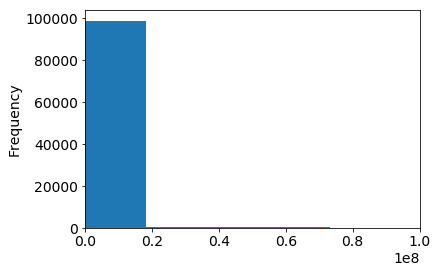

In [13]:
final.transactionRevenue.dropna().astype(int).plot.hist(bins = 300)
plt.xlim(0, 10**8)

In [14]:
final.transactionRevenue.dropna().astype(int).describe()

count    1.000000e+05
mean     1.819409e+06
std      3.901549e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.498000e+09
Name: transactionRevenue, dtype: float64

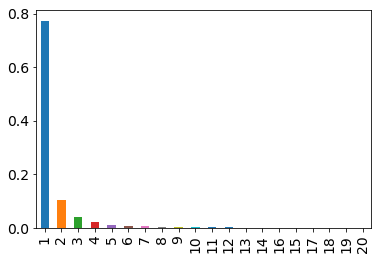

In [15]:
final.visitNumber.value_counts(normalize=True).iloc[0:20].plot.bar()


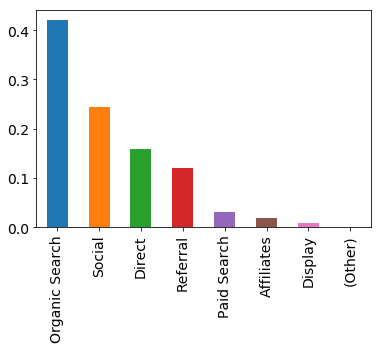

In [16]:
final.channelGrouping.value_counts(normalize=True).plot(kind='bar')

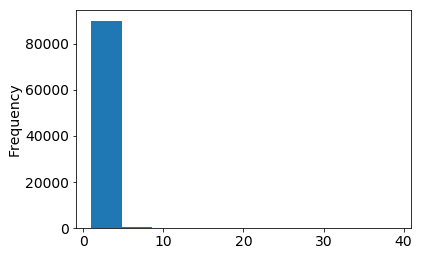

In [17]:
final.fullVisitorId.value_counts().plot(kind='hist')

## Reloading data

In [18]:
# final = final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
# final.to_csv('../data/final_proc.csv',  index = False)

In [19]:
def col_types():
    cat_cols = []
    num_cols = []
    for col, dt in zip(data.dtypes.index, data.dtypes):
        if dt == 'object':
            cat_cols.append(col)
        if dt == 'int64':
            num_cols.append(col)
    return cat_cols, num_cols

In [20]:
try:
    os.makedirs('../../data/out/')
except Exception as e:
    print(e)
    
#filled = final.fillna('-1')
final['adwordsClickInfo.isVideoAd'] = final['adwordsClickInfo.isVideoAd'].fillna(-1).astype(int)
final['isTrueDirect'] = final['isTrueDirect'].fillna(-1).astype(int)
final['fullVisitorId'] = final['fullVisitorId'].astype(str)

final.to_hdf('../../data/out/final.h5', key = 'a', mode = 'w', format = 'table')

[Errno 17] File exists: '../../data/out/'


In [21]:
# %%bash


# zip ../../data/out/train_proc.zip ../../data/out/final_proc.csv
# rm ../../data/out/final_proc.csv
# ls

In [22]:
final = pd.read_hdf('../../data/out/final.h5', 
                    parse_dates = ['date', 'visitStartTime'], 
                    dtype = {'fullvisitorId':float})

#final.visitStartTime = pd.to_datetime(final.visitStartTime, unit = 's')
#final['campaignCode'] = final.campaignCode.fillna('unknown')

In [23]:
# plotly needs api key to work
with open(os.path.expanduser('~') + '/.plotly/credentials.json', 'r') as infile:
    plotly_key = json.load(infile)

tools.set_credentials_file(username=plotly_key['username'], api_key=plotly_key['api_key'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/epy/.plotly/credentials.json'

## Target value

In [ ]:
# plotly charting
data = [go.Histogram(x = final.transactionRevenue.dropna(),
                    xbins=dict(start=0, end=10**9, size = 10000000), 
                    opacity = 0.7
                    )]


layout = go.Layout(title = 'Transaction revenue histogram')
fig = go.Figure(data, layout)
py.iplot(fig)


In [ ]:
# Create a trace
trace = go.Scatter(
    x = final.visitNumber.dropna(0).sample(10000),
    y = final.log_transaction.dropna(0).sample(10000),
    mode = 'markers'
)

layout = go.Layout(
    xaxis=dict(
               range = [0,30]
              )
)
data = [trace]

fig = go.Figure(data, layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')


# Predictors

In [25]:

final['has_transaction'] = (final.transactionRevenue.isnull() == False)*1
final['log_transaction'] = np.log1p(final.transactionRevenue.astype(float))


## Boxplots

In [26]:
from scipy import stats

In [27]:
def find(pattern, string):
    try:
        return re.match(pattern, string).group(0) 
    except:
        pass
    
def num_types(column):
    return len(final[column].value_counts(dropna=False))

In [28]:
col_lens = {col:num_types(col) for col in final.columns.values}

In [29]:
def dict_remove(col_lens):
    remove_list = []
    for key, val in col_lens.items():
        if val == 1:
            remove_list.append(key)

    for item in remove_list:
        col_lens.pop(item)
    return col_lens

In [30]:
col_lens = dict_remove(col_lens)

In [31]:
from pprint import pprint

# print categorical columns

def get_categoricals():
    obj_cols = []
    for i, row in zip(final[list(col_lens.keys())].dtypes.index, final[list(col_lens.keys())].dtypes):
        if row == object and i not in ['fullVisitorId']:
            obj_cols.append(i)
    
    pprint({key:val for key, val in col_lens.items() if key in obj_cols})
    
    return obj_cols

obj_cols = get_categoricals()


{'adContent': 32,
 'adwordsClickInfo.adNetworkType': 3,
 'adwordsClickInfo.gclId': 2390,
 'adwordsClickInfo.page': 5,
 'adwordsClickInfo.slot': 3,
 'bounces': 2,
 'browser': 29,
 'campaign': 8,
 'campaignCode': 2,
 'channelGrouping': 8,
 'city': 290,
 'continent': 6,
 'country': 183,
 'deviceCategory': 3,
 'hits': 165,
 'keyword': 644,
 'medium': 7,
 'metro': 53,
 'networkDomain': 7228,
 'newVisits': 2,
 'operatingSystem': 16,
 'pageviews': 130,
 'referralPath': 528,
 'region': 218,
 'sessionId': 99993,
 'source': 161,
 'subContinent': 23}


In [32]:
obj_cols

['channelGrouping',
 'sessionId',
 'browser',
 'deviceCategory',
 'operatingSystem',
 'city',
 'continent',
 'country',
 'metro',
 'networkDomain',
 'region',
 'subContinent',
 'bounces',
 'hits',
 'newVisits',
 'pageviews',
 'adContent',
 'adwordsClickInfo.adNetworkType',
 'adwordsClickInfo.gclId',
 'adwordsClickInfo.page',
 'adwordsClickInfo.slot',
 'campaign',
 'keyword',
 'medium',
 'referralPath',
 'source',
 'campaignCode']

In [29]:
target_cols = ['has_transaction', 'log_transaction', 'transactionRevenue']
num_cols = [col for col in col_lens if col not in obj_cols + ['date', 'visitStartTime'] + target_cols]
final[num_cols] = final[num_cols].fillna(0)

In [30]:
def boxplot(column:str) -> str:
    
    result = final[column].value_counts().iloc[0:10].index
    _ = final[final[column].apply(lambda item: item in result)].boxplot(column = 'log_transaction', by = column)
    _ = plt.xticks(rotation=90)
    _ = plt.title('')
    _ = plt.suptitle(f"log_transaction by {column}")
    _ = plt.xlabel('')


In [33]:
boxplot('pageviews')

NameError: name 'boxplot' is not defined

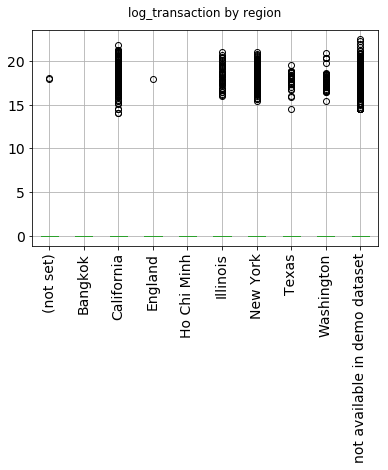

In [32]:
boxplot('region')

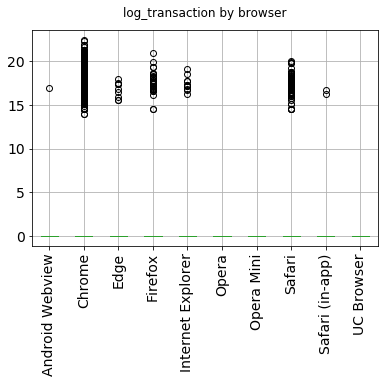

In [34]:
boxplot('browser')

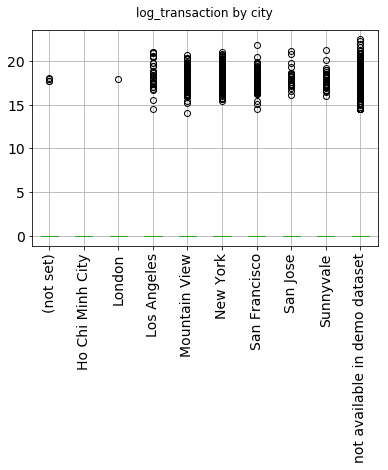

In [33]:
boxplot('city')

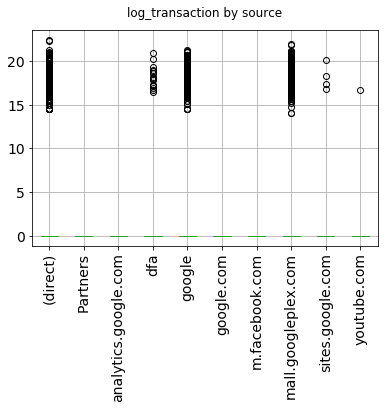

In [35]:
boxplot('source')

In [38]:
feature_cols = [col for col in final.columns if col not in ['transactionRevenue', 'has_transaction', 'log_transaction']]

## Correlation of numeric columns

In [39]:
final[num_cols + ['log_transaction']].corr()

,visitId,visitNumber,isMobile,adwordsClickInfo.isVideoAd,isTrueDirect,log_transaction
visitId,1.000000,0.004475,0.151480,0.047321,0.043364,0.008068
visitNumber,0.004475,1.000000,-0.040382,-0.002460,0.183824,0.022222
isMobile,0.151480,-0.040382,1.000000,0.087597,0.073441,-0.045831
adwordsClickInfo.isVideoAd,0.047321,-0.002460,0.087597,1.000000,-0.050479,0.012061
isTrueDirect,0.043364,0.183824,0.073441,-0.050479,1.000000,0.086777
log_transaction,0.008068,0.022222,-0.045831,0.012061,0.086777,1.000000


## Feature selection

In [40]:
# from sklearn documentation
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
set(feature_cols) ^ set(num_cols + obj_cols)

In [2]:
obj_

NameError: name 'obj_cols' is not defined

In [ ]:
%%time 
result = categorical_pipe.fit_transform(final, final['transactionRevenue'])

In [ ]:
result2 = numerical_pipe.fit_transform(final.fillna(0), final['transactionRevenue'])

In [ ]:
final['has_transaction'].value_counts()

In [43]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import Imputer

# building model with pipes
#categorical_pipe = make_pipeline(ItemSelector(obj_cols), ce.leave_one_out.LeaveOneOutEncoder())
    
#categorical_pipe = make_pipeline(ItemSelector(obj_cols), ce.ordinal.OrdinalEncoder())

categorical_pipe = make_pipeline(ItemSelector(obj_cols), ce.one_hot.OneHotEncoder())
#boolean_pipe = make_pipeline(ItemSelector(booleans), ce.one_hot.OneHotEncoder())

numerical_pipe = make_pipeline(ItemSelector(num_cols), RobustScaler())

transform_pipe = \
make_pipeline(
    FeatureUnion(n_jobs = 8, transformer_list = [
        ('cats', categorical_pipe),
        #('bools', boolean_pipe),
        ('nums', numerical_pipe)
        ])
) 

final_pipe = \
make_pipeline(
    FeatureUnion(n_jobs = 8, transformer_list = [
        ('cats', categorical_pipe),
        #('bools', boolean_pipe),
        ('nums', numerical_pipe)
        ]), 
    ExtraTreesClassifier(n_jobs = 8, n_estimators=250,
                              random_state=0)
)

In [ ]:
transform_pipe.__dict__['steps'][0][1]

In [ ]:
len(obj_cols+num_cols)

In [ ]:
feature_dict = {num:key for num, key in enumerate(obj_cols+num_cols)}

In [ ]:
feature_dict

In [ ]:
from pprint import pprint
transform_pipe.__dict__['steps'][0][1].__dict__['transformer_list'][0][1].__dict__['steps'][0][1].__dict__

In [ ]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
from collections import OrderedDict

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_jobs = 8, n_estimators=250, random_state=0)

result = transform_pipe.fit_transform(final)
forest.fit(result, final['has_transaction'])

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

featimp_dict = OrderedDict()
for f in range(result.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_dict[indices[f]], importances[indices[f]]))
    featimp_dict[feature_dict[indices[f]]] = importances[indices[f]]
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(result.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(result.shape[1]), featimp_dict.keys(), rotation = 90)
plt.xlim([-1, result.shape[1]])
plt.show()

In [ ]:
rf = RandomForestClassifier(random_state = 42, n_jobs = 8, n_estimators=300)
rf.fit(result, final['has_transaction'])

In [ ]:
featimp_dict = {key:val for key, val in zip(obj_cols+num_cols, rf.feature_importances_)}

In [ ]:
featimp_dict.get('channelGrouping')

In [ ]:
from collections import OrderedDict
from operator import itemgetter
forest_imp_order = OrderedDict(sorted(featimp_dict.items(), key=itemgetter(1), reverse=True))



In [ ]:
freq_visitors = final.fullVisitorId.value_counts()[0:20]

In [ ]:
final.head()

In [ ]:
visitor_example = final[final.fullVisitorId == freq_visitors.index[0]].sort_values('visitStartTime')

In [ ]:
visitor_example.columns

In [ ]:
sns.set_style('whitegrid')


In [ ]:
_ = visitor_example[['visitStartTime', 'transactionRevenue']].fillna(0).hist(figsize=(9,6))
_ = plt.xlabel('Dollar amount')
_ = plt.ylabel('Count')
_ = plt.title('Revenue histogram')

In [ ]:
_ = plt.figure(figsize = (9,6))
_ = sns.lineplot(x = 'visitStartTime', y = 'transactionRevenue', data = visitor_example[['visitStartTime', 'transactionRevenue']].fillna(0))
_ = plt.xticks(rotation = 90)

